# Linear Advection-Diffusion

Unknown $C(x, t) \rightarrow \mathbb{R}$ with $x \in [0, R], t \in [0, T]$.

## Physical Assumptions

$$
\begin{align}
C_t & = D \cdot C_{xx} - v \cdot C_x, \\
C_t - D \cdot C_{xx} + v \cdot C_x & = 0.
\end{align}
$$

$$
\begin{align}
C(x, 0) & = C_0(x), \\
C(0, t) & = C(R, t). \\
[C(x, T_l) & = C(x, T)].
\end{align}
$$

## Loss Functions

$$
\mathcal{L} = \mathcal{L}_{\text{PDE}} + \mathcal{L}_{\text{IC}} + \mathcal{L}_{\text{BC}}.
$$

with
$$
\begin{align}
\mathcal{L}_{\text{PDE}} & = \frac{1}{N_P}
    \sum_{i=0}^{N_P}
        {|C_t (x_i, t_i) + D \cdot C_{xx} (x_i, t_i) + v \cdot C_x (x_i, t_i)|^2}, \\
\mathcal{L}_{\text{IC}} & = \frac{1}{N_I}
    \sum_{i=0}^{N_I}
        {|C(x_i, 0) - C_0(x_i)|^2}, \\
\mathcal{L}_{\text{BC}} & = \frac{1}{N_B}
    \sum_{i=0}^{N_B}
        {|C(0, t_i) - C(R, t_i)|^2}.
\end{align}
$$

In [1]:
from Pinn.Pinn import get_model, get_v, get_D
from Pinn.Training import train_pinn, get_training_data, gaussian, convective_dispersion
from Pinn.Plotting import (plot_model_3d,
                           plot_nn,
                           plot_t_animation,
                           plot_difference_to_ref,
                           plot_ref_prediction_comparison,
                           plot_difference_noisy_true_error,
                           plot_nn_colorbar,
                           plot_nn_reference,
                           data_to_function,
                           function_to_data)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Disable warnings, only print errors 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

tf.get_logger().setLevel("ERROR")

--------------- Loaded PINN ---------------
GPU is available ['/physical_device:GPU:0']


## Sine Curve Generation

In [2]:
R, T, N, = 2.*np.pi, 3., 128
sine_model, sine_pinn = get_model(D=0.0, v=0.5, with_data=False)
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     # N_ic=64, N_bc=32,
                                     f_data=None, f_ic=lambda x: np.sin(x))

Epoch 1500 \ [==================================================>] 0.00050 [Batch  0]

[53.07s] Loss: 0.48051 --> 0.00050
Epoch 917 / [==============================================>----] 0.00006 [Batch  3]
Epoch 00918: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 1000 | [==================================================>] 0.00006 [Batch  0]

[35.81s] Loss: 0.00085 --> 0.00006
Epoch 500 / [==================================================>] 0.00004 [Batch  0]

[18.69s] Loss: 0.00011 --> 0.00004


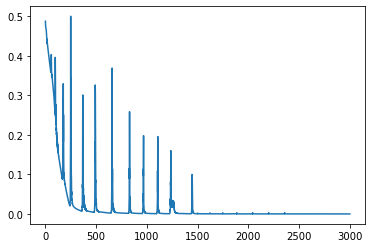

In [3]:
losses = train_pinn(sine_pinn, x_train, y_train, epochs=1500)
losses += train_pinn(sine_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=1000)
losses += train_pinn(sine_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    epochs=500)
plt.plot(np.arange(len(losses)), losses)

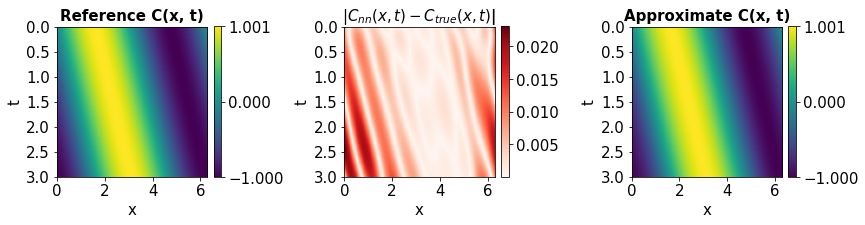

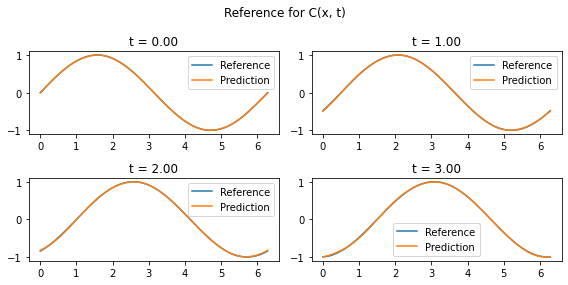

In [4]:
plot_nn_reference(sine_model, R=R, T=T, N=N,
                  ref_data=function_to_data(lambda x, t: np.sin(x - 0.5*t), R, T, N),
                  file_name='sine_gen_3000e_v0p5_err.pdf', title='',
                  show_error=True)
plot_difference_to_ref(sine_model, R=R, max_t=T, N=N,
                       # file_name='sine_gen_3000e_v0p5_time.pdf', title='',
                       ref_f=lambda x, t: np.sin(x - 0.5*t))

### Minimizing the Generalization Error

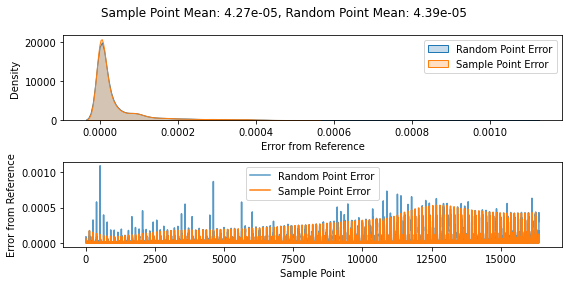

In [62]:
xs, ts = np.meshgrid(np.linspace(0, R, N), np.linspace(0, T, N))
xs, ts = xs.reshape(-1, 1), ts.reshape(-1, 1)
xt = tf.constant(np.concatenate((xs, ts), axis=1))
sample_point_error = (sine_model(xt) - np.sin(xs - 0.5*ts)) ** 2

np.random.seed(51)
xs += np.random.normal(0, 0.1, xs.shape)
np.random.seed(55)
ts += np.random.normal(0, 0.1, ts.shape)
xt = tf.constant(np.concatenate((xs, ts), axis=1))
off_error = (sine_model(xt) - np.sin(xs - 0.5*ts)) ** 2

fig = plt.figure(figsize=(8, 4))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(211)

sns.kdeplot(off_error.numpy().flatten(), fill=True, label='Random Point Error', ax=ax)
sns.kdeplot(sample_point_error.numpy().flatten(), fill=True, label='Sample Point Error', ax=ax)
ax.set_xlabel('Error from Reference')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(off_error, alpha=0.75, label='Random Point Error')
ax.plot(sample_point_error, label='Sample Point Error')
ax.set_xlabel('Sample Point')
ax.set_ylabel('Error from Reference')
ax.legend()

plt.suptitle(f'Sample Point Mean: {np.abs(tf.reduce_mean(sample_point_error).numpy()):.2e}, '
             f'Random Point Mean: {np.abs(tf.reduce_mean(off_error).numpy()):.2e}')
plt.tight_layout()
plt.savefig('sine_generalization_error.pdf', bbox_inches='tight')
plt.show()

In [32]:
xs, ts = np.meshgrid(np.linspace(0, R, N), np.linspace(0, T, N))
xs, ts = xs.reshape(-1, 1), ts.reshape(-1, 1)
xt = tf.constant(np.concatenate((xs, ts), axis=1))
xs_r = xs + np.random.normal(0, 0.1, xs.shape)
ts_r = ts + np.random.normal(0, 0.1, ts.shape)
xt_r = tf.constant(np.concatenate((xs_r, ts_r), axis=1))

Ns = [128, 256, 512]
errors = []

for n in Ns:
    x_train, y_train = get_training_data(R=R, T=T, N=n, f_data=None, f_ic=np.sin)
    m, p = get_model(D=0.0, v=0.5, with_data=False)
    m.set_weights(sine_model.get_weights())
    p.set_weights(sine_pinn.get_weights())
    print(f'Training with {n} sample points per axis')
    train_pinn(p, x_train, y_train,
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
               epochs=50)
    print('--------------------\n')
    sample_point_error = (m(xt) - np.sin(xs - 0.5*ts)) ** 2
    off_error = (m(xt_r) - np.sin(xs_r - 0.5*ts_r)) ** 2
    errors.append(np.abs((tf.reduce_mean(sample_point_error) - tf.reduce_mean(off_error)).numpy()))

fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)
ax.plot(Ns, errors, 'o')
ax.set_xlabel('Number of Sample Points')
ax.set_ylabel('Mean Prediction Error')
for i, v in enumerate(errors):
    ax.text(Ns[i], v+3e-8, f'{v:.1e}', ha="center")
plt.title('Generalization Error')
plt.tight_layout()
plt.show()

Training with 128 sample points per axis
Epoch  50 - [==================================================>] 0.00004 [Batch  0]

[3.06s] Loss: 0.00007 --> 0.00004
--------------------



KeyboardInterrupt: 

In [46]:
x_train_, y_train_ = get_training_data(R=R, T=T, N=N, f_data=None, f_ic=np.sin)
n = np.random.normal(0, 0.1, x_train_[0].shape)

# Add the same noise to inputs
x_train = []
x_train.append(x_train_[0] + n)  # PDE input
x_train.append(tf.concat(
    (tf.reshape(x_train_[1][..., 0] + n[..., 0], (-1, 1)),
     tf.reshape(x_train_[1][..., 1], (-1, 1))), axis=1))  # IC input
x_train.append(tf.concat(
    (tf.reshape(x_train_[2][..., 0], (-1, 1)),
     tf.reshape(x_train_[2][..., 1] + n[..., 1], (-1, 1))), axis=1))  # BC only on t axis
x_train.append(tf.concat(
    (tf.reshape(x_train_[3][..., 0], (-1, 1)),
     tf.reshape(x_train_[3][..., 1] + n[..., 1], (-1, 1))), axis=1))  # BC only on t axis

# Fix initial condition output
y_train = [y_train_[0], None, y_train_[2]]
y_train[1] = tf.constant(np.sin(x_train[1][..., 0]), shape=(N*N, 1))

In [64]:
# sine_t_model, sine_t_pinn = get_model(D=0.0, v=0.5, with_data=False)
# train_pinn(sine_t_pinn, x_train, y_train, epochs=1500)
# train_pinn(sine_t_pinn, x_train, y_train,
#                     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#                     epochs=1000)
# train_pinn(sine_t_pinn, x_train, y_train,
#                     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#                     epochs=500)
train_pinn(sine_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    epochs=500)[-1]

Epoch 500 / [==================================================>] 0.00004 [Batch  0]

[18.88s] Loss: 0.00010 --> 0.00004


4.1055147448787466e-05

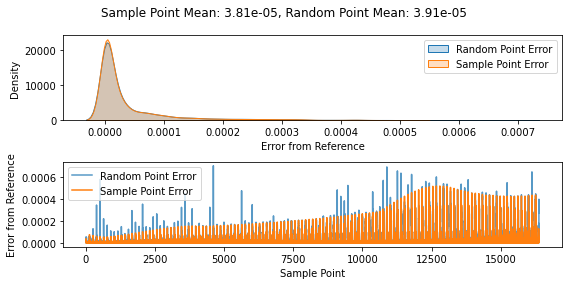

In [66]:
xs, ts = np.meshgrid(np.linspace(0, R, N), np.linspace(0, T, N))
xs, ts = xs.reshape(-1, 1), ts.reshape(-1, 1)
xt = tf.constant(np.concatenate((xs, ts), axis=1))
sample_point_error = (sine_model(xt) - np.sin(xs - 0.5*ts)) ** 2

np.random.seed(51)
xs += np.random.normal(0, 0.1, xs.shape)
np.random.seed(55)
ts += np.random.normal(0, 0.1, ts.shape)
xt = tf.constant(np.concatenate((xs, ts), axis=1))
off_error = (sine_model(xt) - np.sin(xs - 0.5*ts)) ** 2

fig = plt.figure(figsize=(8, 4))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(211)

sns.kdeplot(off_error.numpy().flatten(), fill=True, label='Random Point Error', ax=ax)
sns.kdeplot(sample_point_error.numpy().flatten(), fill=True, label='Sample Point Error', ax=ax)
ax.set_xlabel('Error from Reference')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(off_error, alpha=0.75, label='Random Point Error')
ax.plot(sample_point_error, label='Sample Point Error')
ax.set_xlabel('Sample Point')
ax.set_ylabel('Error from Reference')
ax.legend()

plt.suptitle(f'Sample Point Mean: {np.abs(tf.reduce_mean(sample_point_error).numpy()):.2e}, '
             f'Random Point Mean: {np.abs(tf.reduce_mean(off_error).numpy()):.2e}')
plt.tight_layout()
plt.savefig('sine_generalization_trained_error.pdf', bbox_inches='tight')
plt.show()

## Gaussian Curve Generation

In [2]:
R, T, N = 2.0, 3.0, 128
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     f_data=None,
                                     f_ic=partial(gaussian, mu=1.0, sig=0.2))

In [3]:
gauss_model, gauss_pinn = get_model(D=0.0, v=0.5, with_data=False)

Epoch 750 \ [==================================================>] 0.03103 [Batch  0]

[27.12s] Loss: 0.18270 --> 0.03103
Epoch 750 \ [==================================================>] 0.00748 [Batch  0]

[27.12s] Loss: 0.03352 --> 0.00748
Epoch 750 \ [==================================================>] 0.00043 [Batch  0]

[27.00s] Loss: 0.00915 --> 0.00043


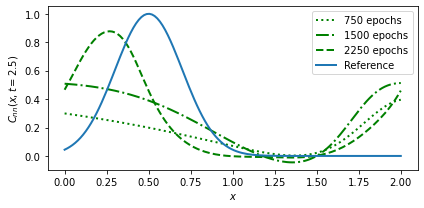

In [164]:
gauss_model_copy, gauss_pinn_copy = get_model(D=0.0, v=0.5, with_data=False)
t = 2.5
xs = np.linspace(0., R, N).reshape(-1, 1)
ts = np.full(xs.shape, t)

fig = plt.figure(figsize=(6, 3))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)

epoch_per_step = 750
for i, style in enumerate(['g:', 'g-.', 'g--']):
    losses = train_pinn(gauss_pinn_copy, x_train, y_train, epochs=epoch_per_step)

    ax.set_xlabel('$x$')
    ax.set_ylabel(f'$C_{{nn}}(x, t={t})$')
    ax.plot(xs, gauss_model_copy(tf.concat((xs, ts), axis=1)), style, linewidth=2, label=f'{(i+1)*epoch_per_step} epochs')

ax.plot(xs, gaussian(xs.flatten(), mu=-2. + t, sig=0.2), linewidth=2, label=f'Reference')
plt.legend()
plt.tight_layout()
plt.savefig('gauss_results_while_learning.pdf')
plt.show()

Epoch 1500 \ [==================================================>] 0.00856 [Batch  0]

[55.56s] Loss: 0.18270 --> 0.00856
Epoch 1500 \ [==================================================>] 0.00061 [Batch  0]

[55.91s] Loss: 0.01088 --> 0.00061
Epoch 1500 \ [==================================================>] 0.00008 [Batch  0]

[55.82s] Loss: 0.00062 --> 0.00008


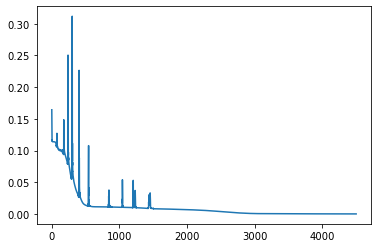

In [4]:
losses = train_pinn(gauss_pinn, x_train, y_train, epochs=1500)
losses += train_pinn(gauss_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=1500)
losses += train_pinn(gauss_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    epochs=1500)
plt.plot(np.arange(len(losses)), losses)

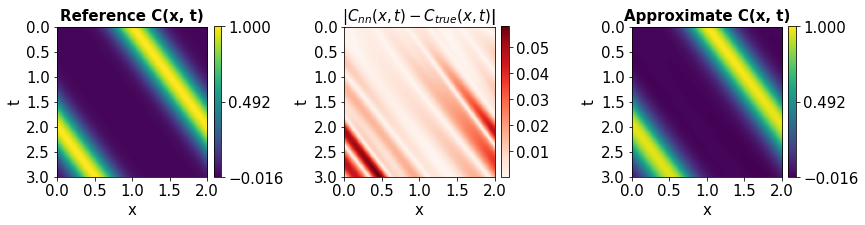

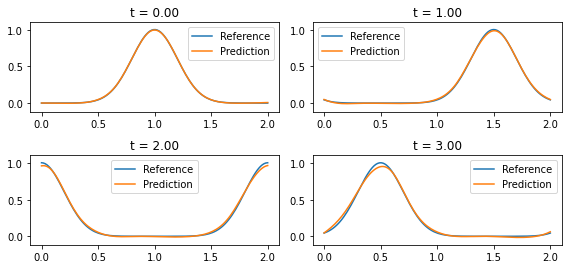

In [17]:
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(0., T, N))
plot_nn_reference(gauss_model, R=R, T=T, N=N,
                  ref_data=gaussian(xs - 0.5*ts, 1.0, 0.2) + gaussian(xs - 0.5*ts + 2., 1., 0.2),
                  show_error=True,
                  file_name='gauss_gen_3000e_v0p5_err.pdf', title=''
                 )
plot_difference_to_ref(gauss_model, R=R, max_t=T, N=N,
                      ref_f=lambda x, t: gaussian(x - 0.5*t, 1.0, 0.2) + gaussian(x - 0.5*t + 2., 1.0, 0.2),
                      file_name='gauss_gen_3000e_v0p5_time.pdf', title=''
                      )

## Sine Curve - Data Driven

In [5]:
R, T, N, = 2.*np.pi, 3., 128
sine2_model, sine2_pinn = get_model(D=0.0, v=0.5)  # Initial v

In [6]:
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     f_data=lambda x, t: np.sin(x - 0.5*t),
                                     f_ic=np.sin)

Epoch 1500 \ [==================================================>] 0.00089 [Batch  0]

[57.46s] Loss: 0.96450 --> 0.00089
Epoch 1000 | [==================================================>] 0.00024 [Batch  0]

[38.39s] Loss: 0.00079 --> 0.00024
Epoch 500 / [==================================================>] 0.00019 [Batch  0]

[19.98s] Loss: 0.00016 --> 0.00019


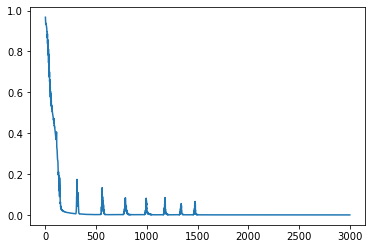

In [7]:
losses = train_pinn(sine2_pinn, x_train, y_train, epochs=1500)
losses += train_pinn(sine2_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=1000)
losses += train_pinn(sine2_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    epochs=500)

plt.plot(np.arange(len(losses)), losses)

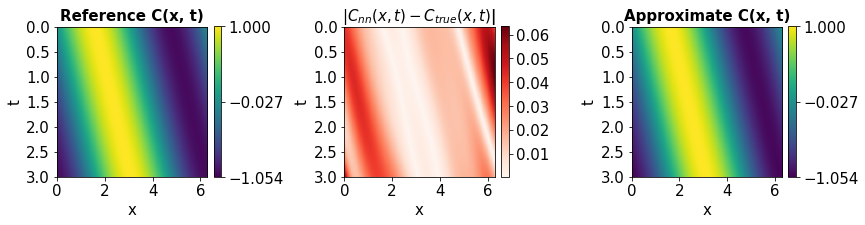

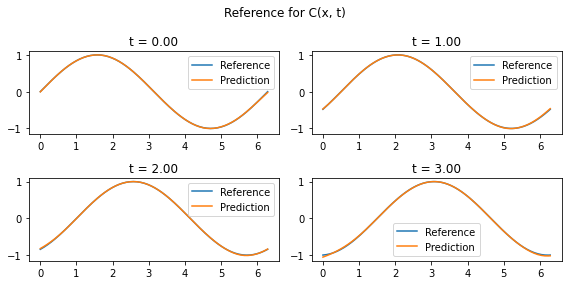

In [8]:
plot_nn_reference(sine2_model, R=R, T=T, N=N, ref_data=y_train[0],
                  file_name='sine_gen_w_data_3000e_v0p5_err.pdf', title='',
                  show_error=True)
plot_difference_to_ref(sine2_model, R=R, max_t=T, N=N,
                       # file_name='sine_gen_w_data_3000e_v0p5_time.pdf', title='',
                       ref_f=lambda x, t: np.sin(x - 0.5*t))

## Sine Curve - Learning v

In [4]:
R, T, N, = 2.*np.pi, 3., 128
sine3_model, sine3_pinn = get_model(D=0.0, v={'trainable': True, 'value': -0.2})  # Initial v

In [5]:
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     f_data=lambda x, t: np.sin(x - 0.5*t),
                                     f_ic=np.sin)

Epoch 1500 \ [==================================================>] 0.00081 [Batch  0]

[59.06s] Loss: 0.96436 --> 0.00081
Epoch 1000 | [==================================================>] 0.00027 [Batch  0]

[39.07s] Loss: 0.00058 --> 0.00027
Epoch 500 / [==================================================>] 0.00020 [Batch  0]

[20.37s] Loss: 0.00018 --> 0.00020
Found v = 0.4985


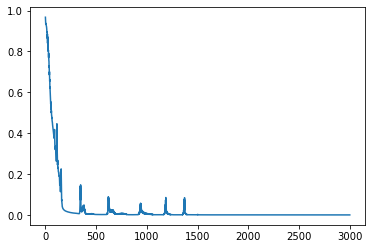

In [6]:
losses = train_pinn(sine3_pinn, x_train, y_train, epochs=1500)
losses += train_pinn(sine3_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=1000)
losses += train_pinn(sine3_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    epochs=500)
plt.plot(np.arange(len(losses)), losses)
print(f'Found v = {get_v(sine3_pinn):.4f}')

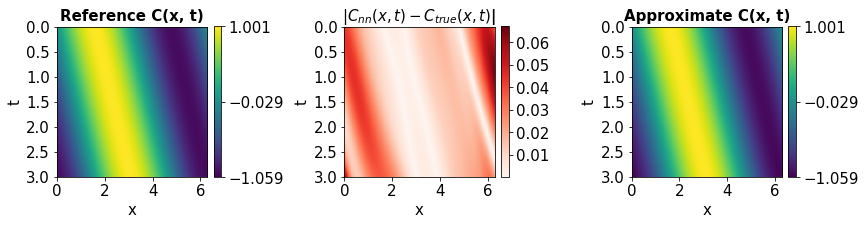

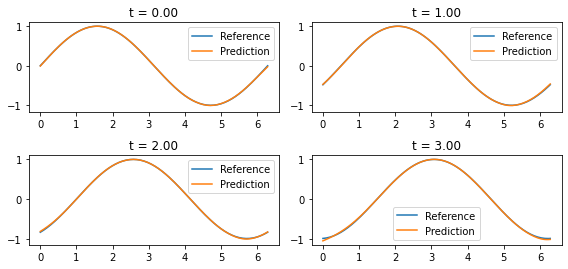

In [7]:
plot_nn_reference(sine3_model, R=R, T=T, N=N, ref_data=y_train[0],
                  # file_name='sine_data_3000e_v0p5_err.pdf', title='',
                  show_error=True)
plot_difference_to_ref(sine3_model, R=R, max_t=T, N=N,
                       # file_name='sine_data_3000e_v0p5_time.pdf', title='',
                       ref_f=lambda x, t: np.sin(x - 0.5*t))

## Sine Curve - Noisy - Learning v

In [2]:
R, T, N, = 2.*np.pi, 3., 128
sine4_model, sine4_pinn = get_model(D=0.0, v={'trainable': True, 'value': -0.2})  # Initial v

In [3]:
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     f_data=lambda x, t: np.sin(x - 0.5*t),
                                     f_ic=np.sin,
                                     data_noise=0.1)  # => Normal(0, 0.2), sigma = max(sin) - min(sin)) * 0.1 = (1 - (-1)) * 0.1 

Epoch 1500 \ [==================================================>] 0.04140 [Batch  0]

[59.70s] Loss: 0.99632 --> 0.04140
Epoch 918 / [==============================================>----] 0.04101 [Batch  3]
Epoch 00919: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 1000 | [==================================================>] 0.04096 [Batch  0]

[40.50s] Loss: 0.04051 --> 0.04096
Epoch 500 / [==================================================>] 0.04095 [Batch  0]

[21.08s] Loss: 0.04013 --> 0.04095
Found v = 0.4991


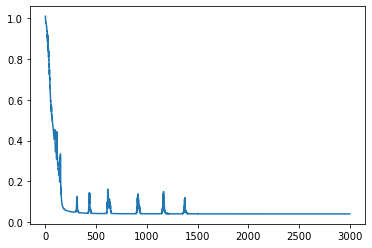

In [4]:
losses = train_pinn(sine4_pinn, x_train, y_train, epochs=1500)
losses += train_pinn(sine4_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=1000)
losses += train_pinn(sine4_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    epochs=500)
plt.plot(np.arange(len(losses)), losses)
print(f'Found v = {get_v(sine4_pinn):.4f}')

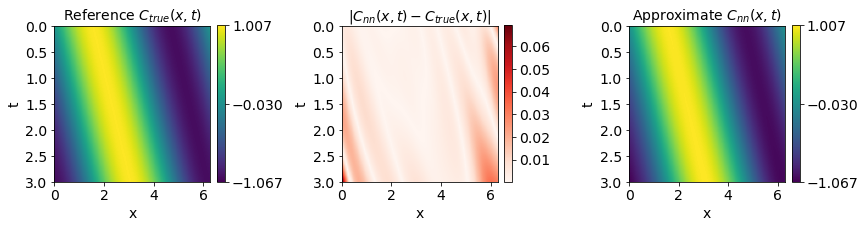

In [24]:
tick_size = 14
show_error = True
ratio = 0.046
fig = plt.figure(figsize=plt.figaspect(0.33 if show_error else 0.5))
fig.patch.set_facecolor('white')

# Reference Data
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(0., T, N))
Z_ref = tf.reshape(np.sin(xs - 0.5*ts), (N, N))
# Z_ref = tf.reshape(y_train[0], (N, N))

# Prediction Data
Xs, Ts = np.meshgrid(np.linspace(0., R, N), np.linspace(0, T, N))
Z = sine4_model(tf.concat(
    (Xs.reshape(-1, 1), Ts.reshape(-1, 1)), axis=1)
              ).numpy().reshape(Xs.shape)

# Calculate scale
low_tick = np.min(np.concatenate((Z, Z_ref)))
high_tick = np.max(np.concatenate((Z, Z_ref)))
ticks = np.linspace(low_tick, high_tick, 3)

# Reference
subplot = 131 if show_error else 121
ax = fig.add_subplot(subplot)

im_ref = ax.imshow(Z_ref, extent=[0., R, T, 0], aspect=R/T, vmin=low_tick, vmax=high_tick)
ax.set_xlabel('x', size=tick_size)
ax.set_ylabel('t', size=tick_size)
plt.xticks(size=tick_size)
plt.yticks(size=tick_size)
ax.set_title('Reference $C_{true}(x, t)$', fontsize=tick_size)
cb = plt.colorbar(im_ref, ticks=ticks, fraction=ratio, pad=0.04)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(tick_size)

# Prediction
subplot = 133 if show_error else 122
ax = fig.add_subplot(subplot)

im = ax.imshow(Z, extent=[0., R, T, 0], aspect=R/T, vmin=low_tick, vmax=high_tick)
ax.set_xlabel('x', size=tick_size)
ax.set_ylabel('t', size=tick_size)
plt.xticks(size=tick_size)
plt.yticks(size=tick_size)
ax.set_title('Approximate $C_{nn}(x, t)$', fontsize=tick_size)
cb = plt.colorbar(im, ticks=ticks, fraction=ratio, pad=0.04)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(tick_size)

# Error
if show_error:
    Z_err = np.abs(Z_ref - Z)
    ax = fig.add_subplot(132)

    im = ax.imshow(Z_err, extent=[0., R, T, 0], aspect=R/T, cmap='Reds')
    ax.set_xlabel('x', size=tick_size)
    ax.set_ylabel('t', size=tick_size)
    plt.xticks(size=tick_size)
    plt.yticks(size=tick_size)
    ax.set_title('$|C_{nn}(x, t) - C_{true}(x, t)$|', fontsize=tick_size)
    cb = plt.colorbar(im, fraction=ratio, pad=0.04)
    for t in cb.ax.get_yticklabels():
         t.set_fontsize(tick_size)

plt.tight_layout()

plt.savefig('sine_noise_data_3000e_err.pdf', bbox_inches='tight')
plt.show()

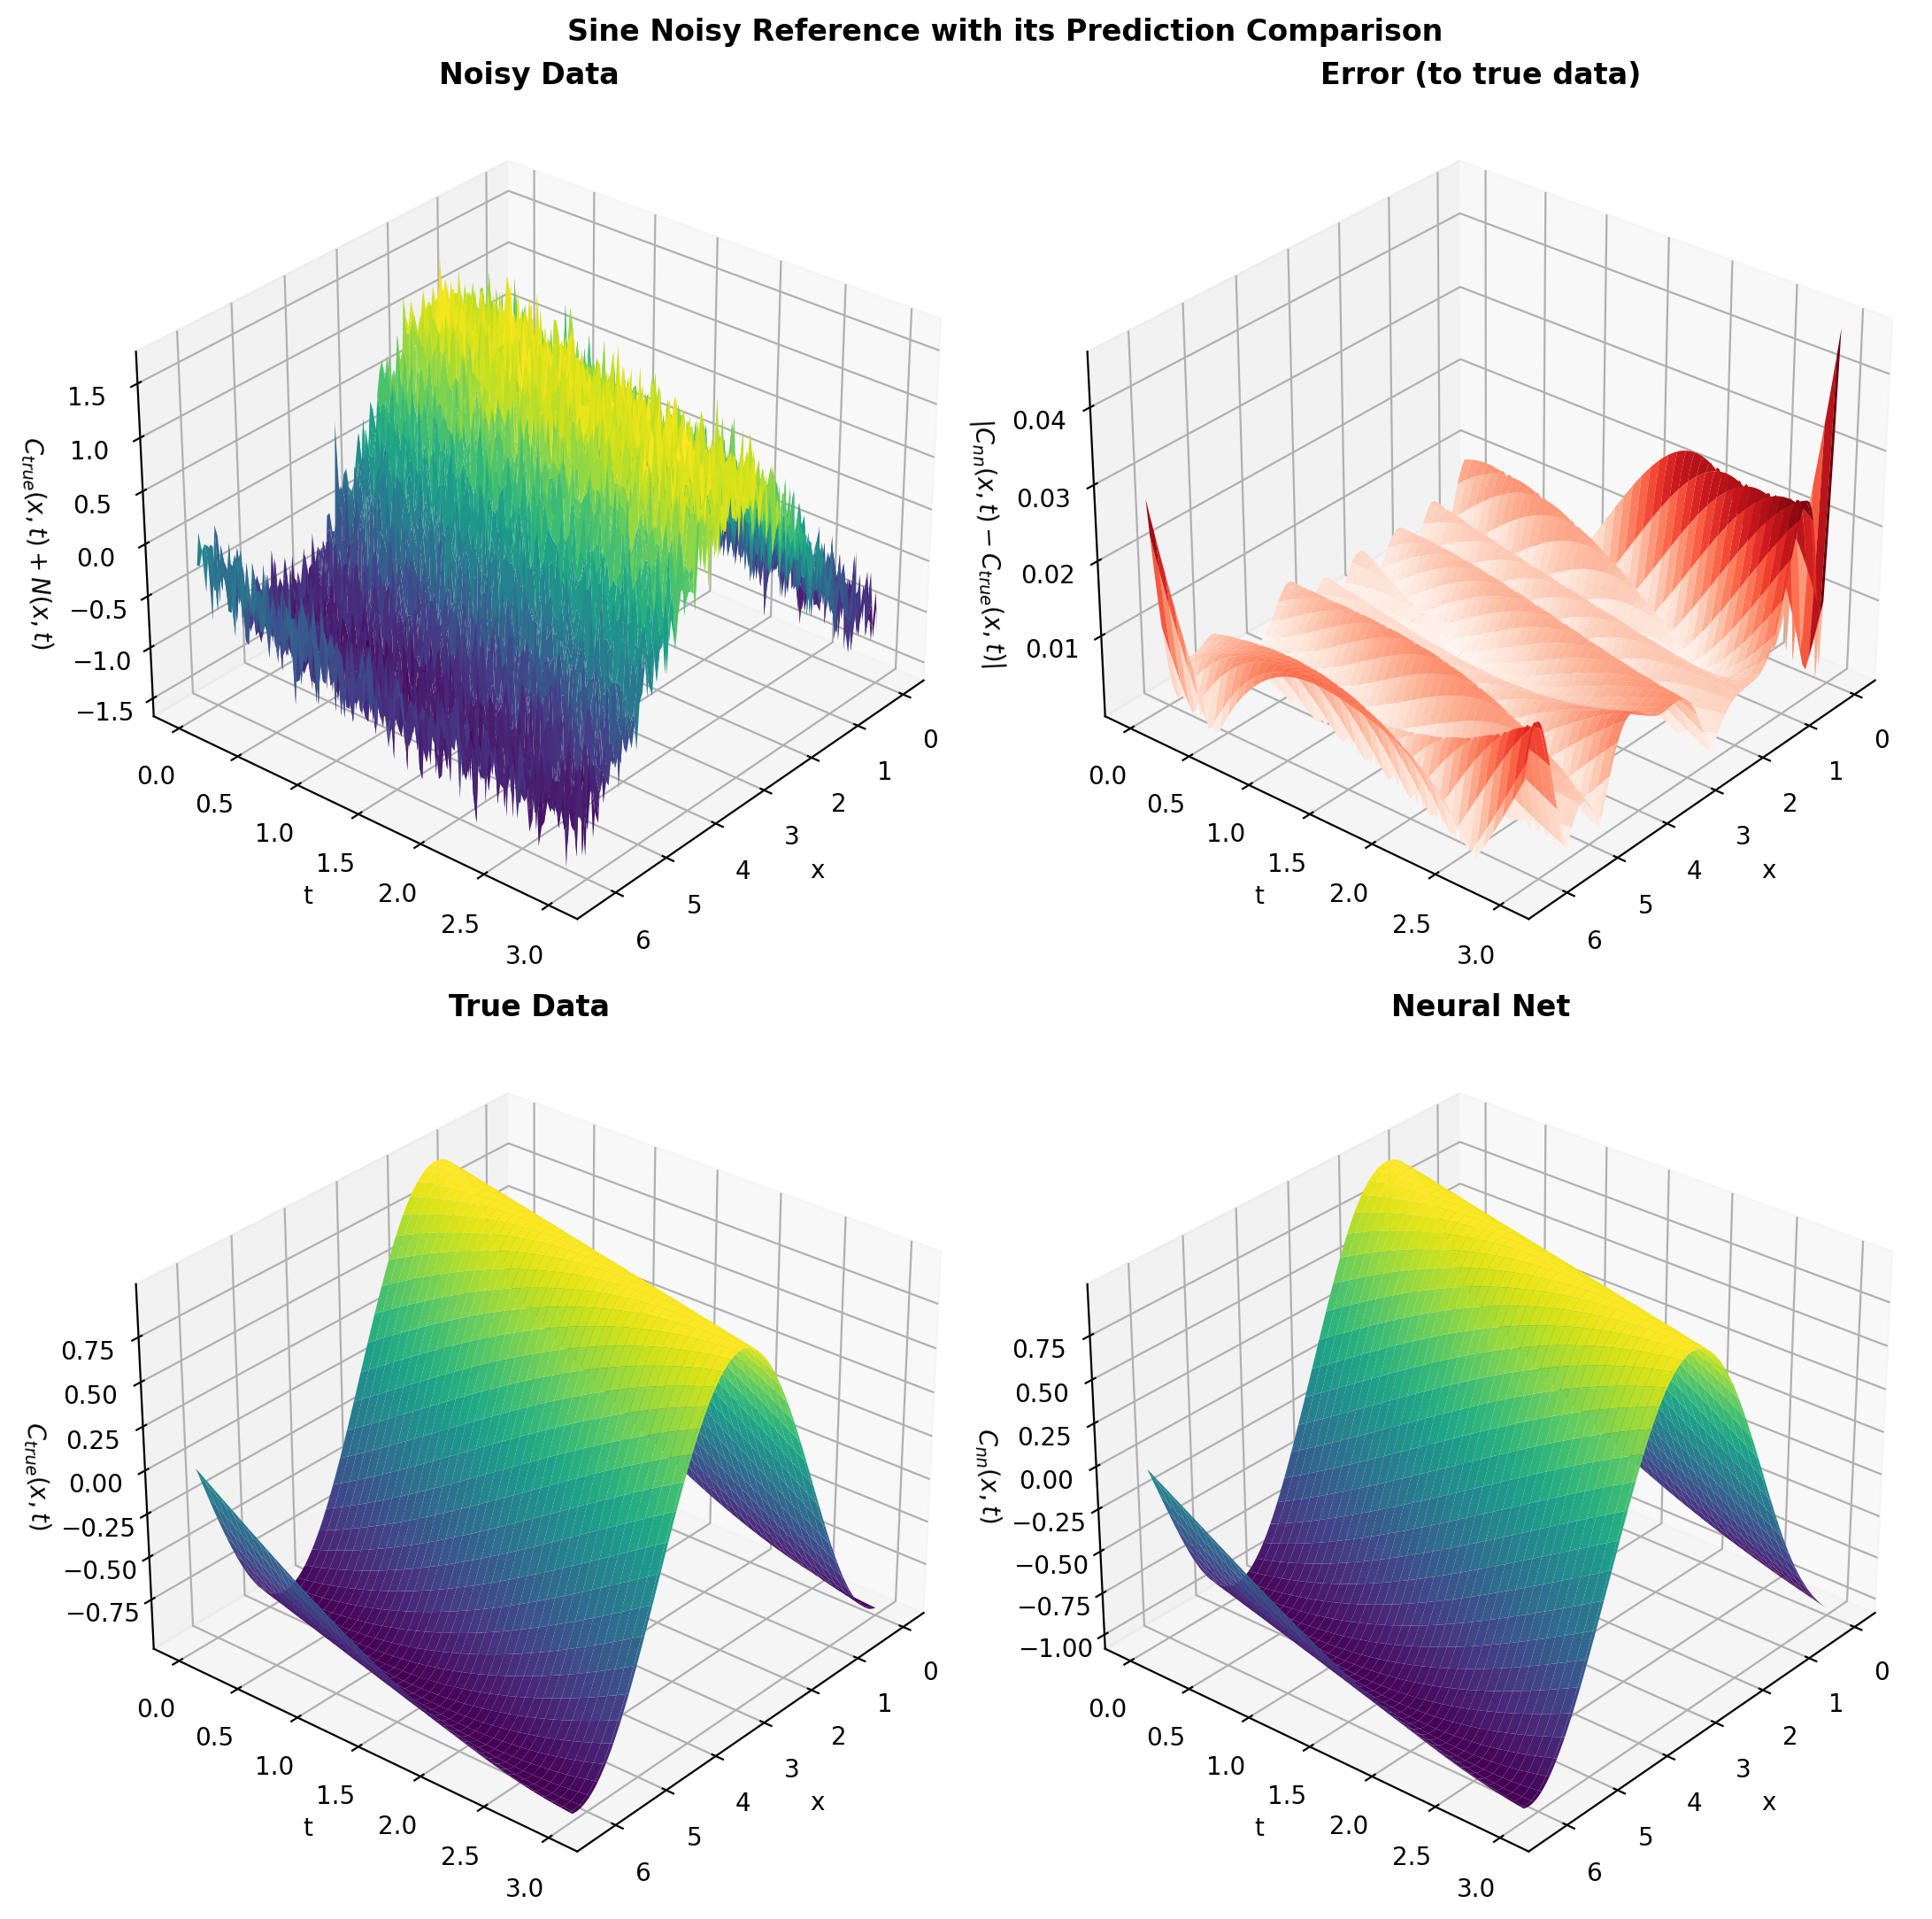

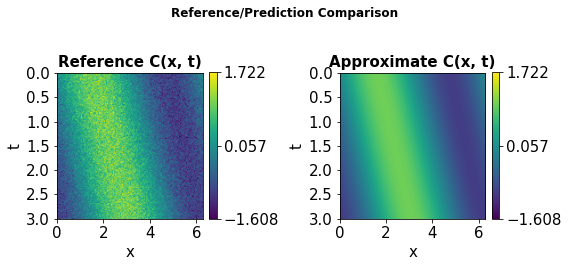

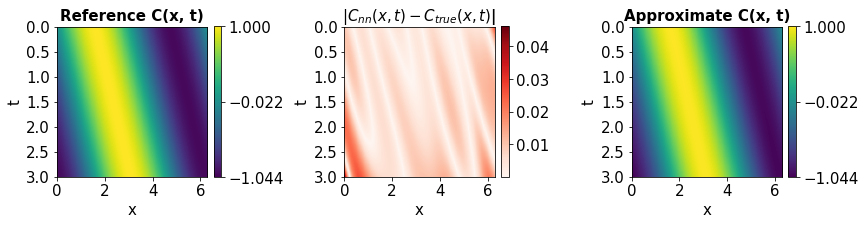

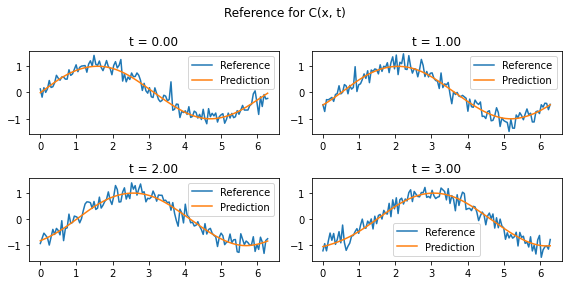

In [48]:
plot_difference_noisy_true_error(sine4_model, R=R, T=T, N=N,
                                 noisy_ref_data=y_train[0],
                                 true_ref_f=lambda x, t: np.sin(x - 0.5*t),
                                 title_fn_name='Sine'
                                 # file_name='sine_noise_data_3000e_err_ref.pdf', title=''
                                )
plot_nn_reference(sine4_model, R=R, T=T, N=N, ref_data=y_train[0],
                  # file_name='sine_noise_data_3000e_diff.pdf', title='',
                 )
plot_nn_reference(sine4_model, R=R, T=T, N=N,
                  ref_data=function_to_data(lambda x, t: np.sin(x - 0.5*t), R, T, N),
                  show_error=True,
                  file_name='sine_noise_data_3000e_err.pdf', title='',
                  # title='Prediction of Noisy Data to True Data Comparison'
                 )
plot_difference_to_ref(sine4_model, R=R, N=N, max_t=T,
                       ref_f=data_to_function(y_train[0], R=R, T=T, N=N),
                       # file_name='sine_noise_data_3000e_time.pdf', title=f'Found v = {get_v(sine4_pinn):.4f}; True v = 0.5'
                       # title=f'Reference, Found v = {get_v(sine4_pinn):.4f}, true v = 0.5'
                      )

In [17]:
print('Mean  ', tf.reduce_mean(tf.keras.losses.mean_squared_error(sine4_pinn(x_train), y_train)).numpy())
y_pred = sine4_pinn(x_train)
print('Custom', tf.reduce_mean((
    (y_pred[0] - y_train[0]) ** 2 +  # data
    (y_pred[1] - y_train[1]) ** 2 +  # pde
    (y_pred[2] - y_train[2]) ** 2 + # ic
    (y_pred[3] - y_train[3]) ** 2  # bc
       ) / 4.
).numpy())

print('')
print(f'Data  {tf.reduce_mean((y_pred[0] - y_train[0]) ** 2).numpy():.3e}')
print(f'PDE   {tf.reduce_mean((y_pred[1] - y_train[1]) ** 2).numpy():.3e}')
print(f'IC    {tf.reduce_mean((y_pred[2] - y_train[2]) ** 2).numpy():.3e}')
print(f'BC    {tf.reduce_mean((y_pred[3] - y_train[3]) ** 2).numpy():.3e}')

Mean   0.010056576
Custom 0.010056576

Data  4.002e-02
PDE   2.261e-05
IC    3.096e-05
BC    1.514e-04


## Sine Curve - Sparse Data

In [2]:
R, T, N, = 2.*np.pi, 3., 128
sine5_model, sine5_pinn = get_model(D=0.0, v={'trainable': True, 'value': -0.2})  # Initial v

In [3]:
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     f_data=lambda x, t: np.sin(x - 0.5*t),
                                     f_ic=np.sin,
                                     drop_values=0.9)

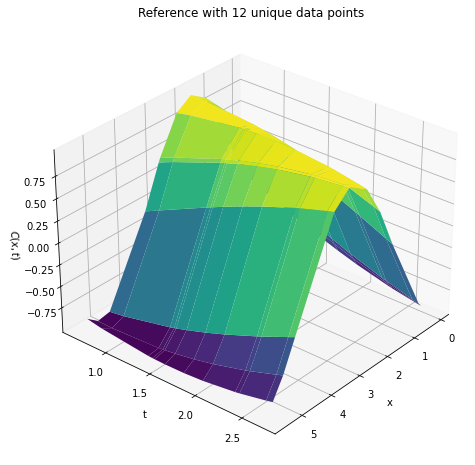

In [4]:
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x_train[0][..., 0][:128], x_train[0][..., 1][0::128])
Z = tf.reshape(y_train[0], X.shape)

ax.plot_surface(X, Y, Z, cmap='viridis')
ax.view_init(30, 40)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$C(x, t)$')

plt.title(f"Reference with {np.unique(x_train[0][..., 0][:128]).shape[0]} unique data points")
plt.show()
print()

Epoch 1500 \ [==================================================>] 0.00448 [Batch  0]

[58.72s] Loss: 0.98365 --> 0.00448
Epoch 1000 | [==================================================>] 0.00015 [Batch  0]

[39.12s] Loss: 0.02760 --> 0.00015
Epoch 500 / [==================================================>] 0.00011 [Batch  0]

[20.24s] Loss: 0.00008 --> 0.00011
Found v = 0.4987


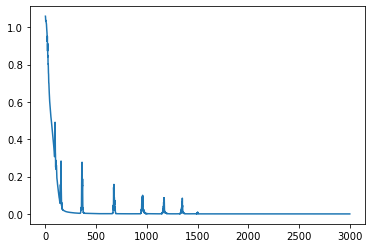

In [5]:
losses = train_pinn(sine5_pinn, x_train, y_train, epochs=1500)
losses += train_pinn(sine5_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=1000)
losses += train_pinn(sine5_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    epochs=500)
plt.plot(np.arange(len(losses)), losses)
print(f'Found v = {get_v(sine5_pinn):.4f}')

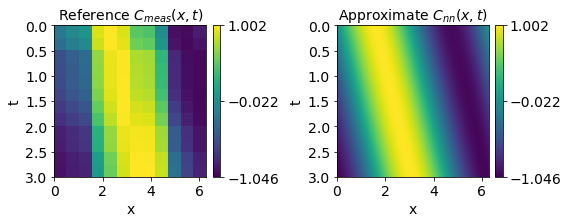

In [8]:
tick_size = 14
show_error = False
ratio = 0.046
fig = plt.figure(figsize=plt.figaspect(0.33 if show_error else 0.5))
fig.patch.set_facecolor('white')

# Reference Data
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(0., T, N))
# Z_ref = tf.reshape(np.sin(xs - 0.5*ts), (N, N))
Z_ref = tf.reshape(y_train[0], (N, N))

# Prediction Data
Xs, Ts = np.meshgrid(np.linspace(0., R, N), np.linspace(0, T, N))
Z = sine5_model(tf.concat(
    (Xs.reshape(-1, 1), Ts.reshape(-1, 1)), axis=1)
              ).numpy().reshape(Xs.shape)

# Calculate scale
low_tick = np.min(np.concatenate((Z, Z_ref)))
high_tick = np.max(np.concatenate((Z, Z_ref)))
ticks = np.linspace(low_tick, high_tick, 3)

# Reference
subplot = 131 if show_error else 121
ax = fig.add_subplot(subplot)

im_ref = ax.imshow(Z_ref, extent=[0., R, T, 0], aspect=R/T, vmin=low_tick, vmax=high_tick)
ax.set_xlabel('x', size=tick_size)
ax.set_ylabel('t', size=tick_size)
plt.xticks(size=tick_size)
plt.yticks(size=tick_size)
ax.set_title('Reference $C_{meas}(x, t)$', fontsize=tick_size)
cb = plt.colorbar(im_ref, ticks=ticks, fraction=ratio, pad=0.04)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(tick_size)

# Prediction
subplot = 133 if show_error else 122
ax = fig.add_subplot(subplot)

im = ax.imshow(Z, extent=[0., R, T, 0], aspect=R/T, vmin=low_tick, vmax=high_tick)
ax.set_xlabel('x', size=tick_size)
ax.set_ylabel('t', size=tick_size)
plt.xticks(size=tick_size)
plt.yticks(size=tick_size)
ax.set_title('Approximate $C_{nn}(x, t)$', fontsize=tick_size)
cb = plt.colorbar(im, ticks=ticks, fraction=ratio, pad=0.04)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(tick_size)

# Error
if show_error:
    Z_err = np.abs(Z_ref - Z)
    ax = fig.add_subplot(132)

    im = ax.imshow(Z_err, extent=[0., R, T, 0], aspect=R/T, cmap='Reds')
    ax.set_xlabel('x', size=tick_size)
    ax.set_ylabel('t', size=tick_size)
    plt.xticks(size=tick_size)
    plt.yticks(size=tick_size)
    ax.set_title('$|C_{nn}(x, t) - C_{true}(x, t)$|', fontsize=tick_size)
    cb = plt.colorbar(im, fraction=ratio, pad=0.04)
    for t in cb.ax.get_yticklabels():
         t.set_fontsize(tick_size)

plt.tight_layout()

plt.savefig('sine_sparse_data_3000e_diff.pdf', bbox_inches='tight')
plt.show()

In [ ]:
print('Mean  ', tf.reduce_mean(tf.keras.losses.mean_squared_error(sine5_pinn(x_train), y_train)).numpy())
y_pred = sine5_pinn(x_train)
print('Custom', tf.reduce_mean((
    (y_pred[0] - y_train[0]) ** 2 +  # data
    (y_pred[1] - y_train[1]) ** 2 +  # pde
    (y_pred[2] - y_train[2]) ** 2 + # ic
    (y_pred[3] - y_train[3]) ** 2  # bc
       ) / 4.
).numpy())

print('')
print(f'Data  {tf.reduce_mean((y_pred[0] - y_train[0]) ** 2).numpy():.3e}')
print(f'PDE   {tf.reduce_mean((y_pred[1] - y_train[1]) ** 2).numpy():.3e}')
print(f'IC    {tf.reduce_mean((y_pred[2] - y_train[2]) ** 2).numpy():.3e}')
print(f'BC    {tf.reduce_mean((y_pred[3] - y_train[3]) ** 2).numpy():.3e}')

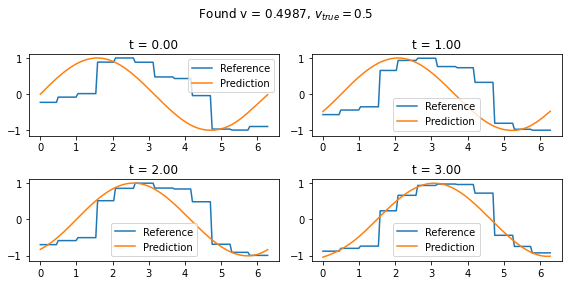

In [23]:
x_range = np.linspace(0, R, N)

ts = np.linspace(0, T, 4)
fig = plt.figure(figsize=(8, 4))
fig.patch.set_facecolor('white')
y_min, y_max = 99999, -999999 
axes = []
for i in range(4):
    subplot = 221 + i
    ax = fig.add_subplot(subplot)
    axes.append(ax)

    ref = y_train[0].numpy().reshape((N, N))[i*32]
    y_min = np.min(ref) if np.min(ref) < y_min else y_min
    y_max = np.max(ref) if np.max(ref) > y_max else y_max
    ax.plot(x_range, ref, label='Reference')

    xt = tf.concat((x_range[:, None], tf.constant(
        ts[i], shape=x_range[:, None].shape)), axis=1)

    pred = sine5_model(xt)
    y_min = np.min(pred) if np.min(pred) < y_min else y_min
    y_max = np.max(pred) if np.max(pred) > y_max else y_max
    ax.plot(x_range, pred, label='Prediction')
    ax.title.set_text(f't = {ts[i]:.2f}')
    ax.legend()

for ax in axes:
    ax.set_ylim([y_min-0.1, y_max+0.1])
plt.suptitle(f' Found v = {get_v(sine5_pinn):.4f}, $v_{{true}} = 0.5$')
plt.tight_layout()
plt.savefig('sine_sparse_data_3000e_time.pdf', bbox_inches='tight')
plt.show()

In [24]:
print('Mean  ', tf.reduce_mean(tf.keras.losses.mean_squared_error(sine5_pinn(x_train), y_train)).numpy())
y_pred = sine5_pinn(x_train)
print('Custom', tf.reduce_mean((
    (y_pred[0] - y_train[0]) ** 2 +  # data
    (y_pred[1] - y_train[1]) ** 2 +  # pde
    (y_pred[2] - y_train[2]) ** 2 + # ic
    (y_pred[3] - y_train[3]) ** 2  # bc
       ) / 4.
).numpy())

print('')
print(f'Data  {tf.reduce_mean((y_pred[0] - y_train[0]) ** 2).numpy():.3e}')
print(f'PDE   {tf.reduce_mean((y_pred[1] - y_train[1]) ** 2).numpy():.3e}')
print(f'IC    {tf.reduce_mean((y_pred[2] - y_train[2]) ** 2).numpy():.3e}')
print(f'BC    {tf.reduce_mean((y_pred[3] - y_train[3]) ** 2).numpy():.3e}')

Mean   2.6249278e-05
Custom 2.624928e-05

Data  1.344e-05
PDE   2.263e-05
IC    7.925e-06
BC    6.100e-05


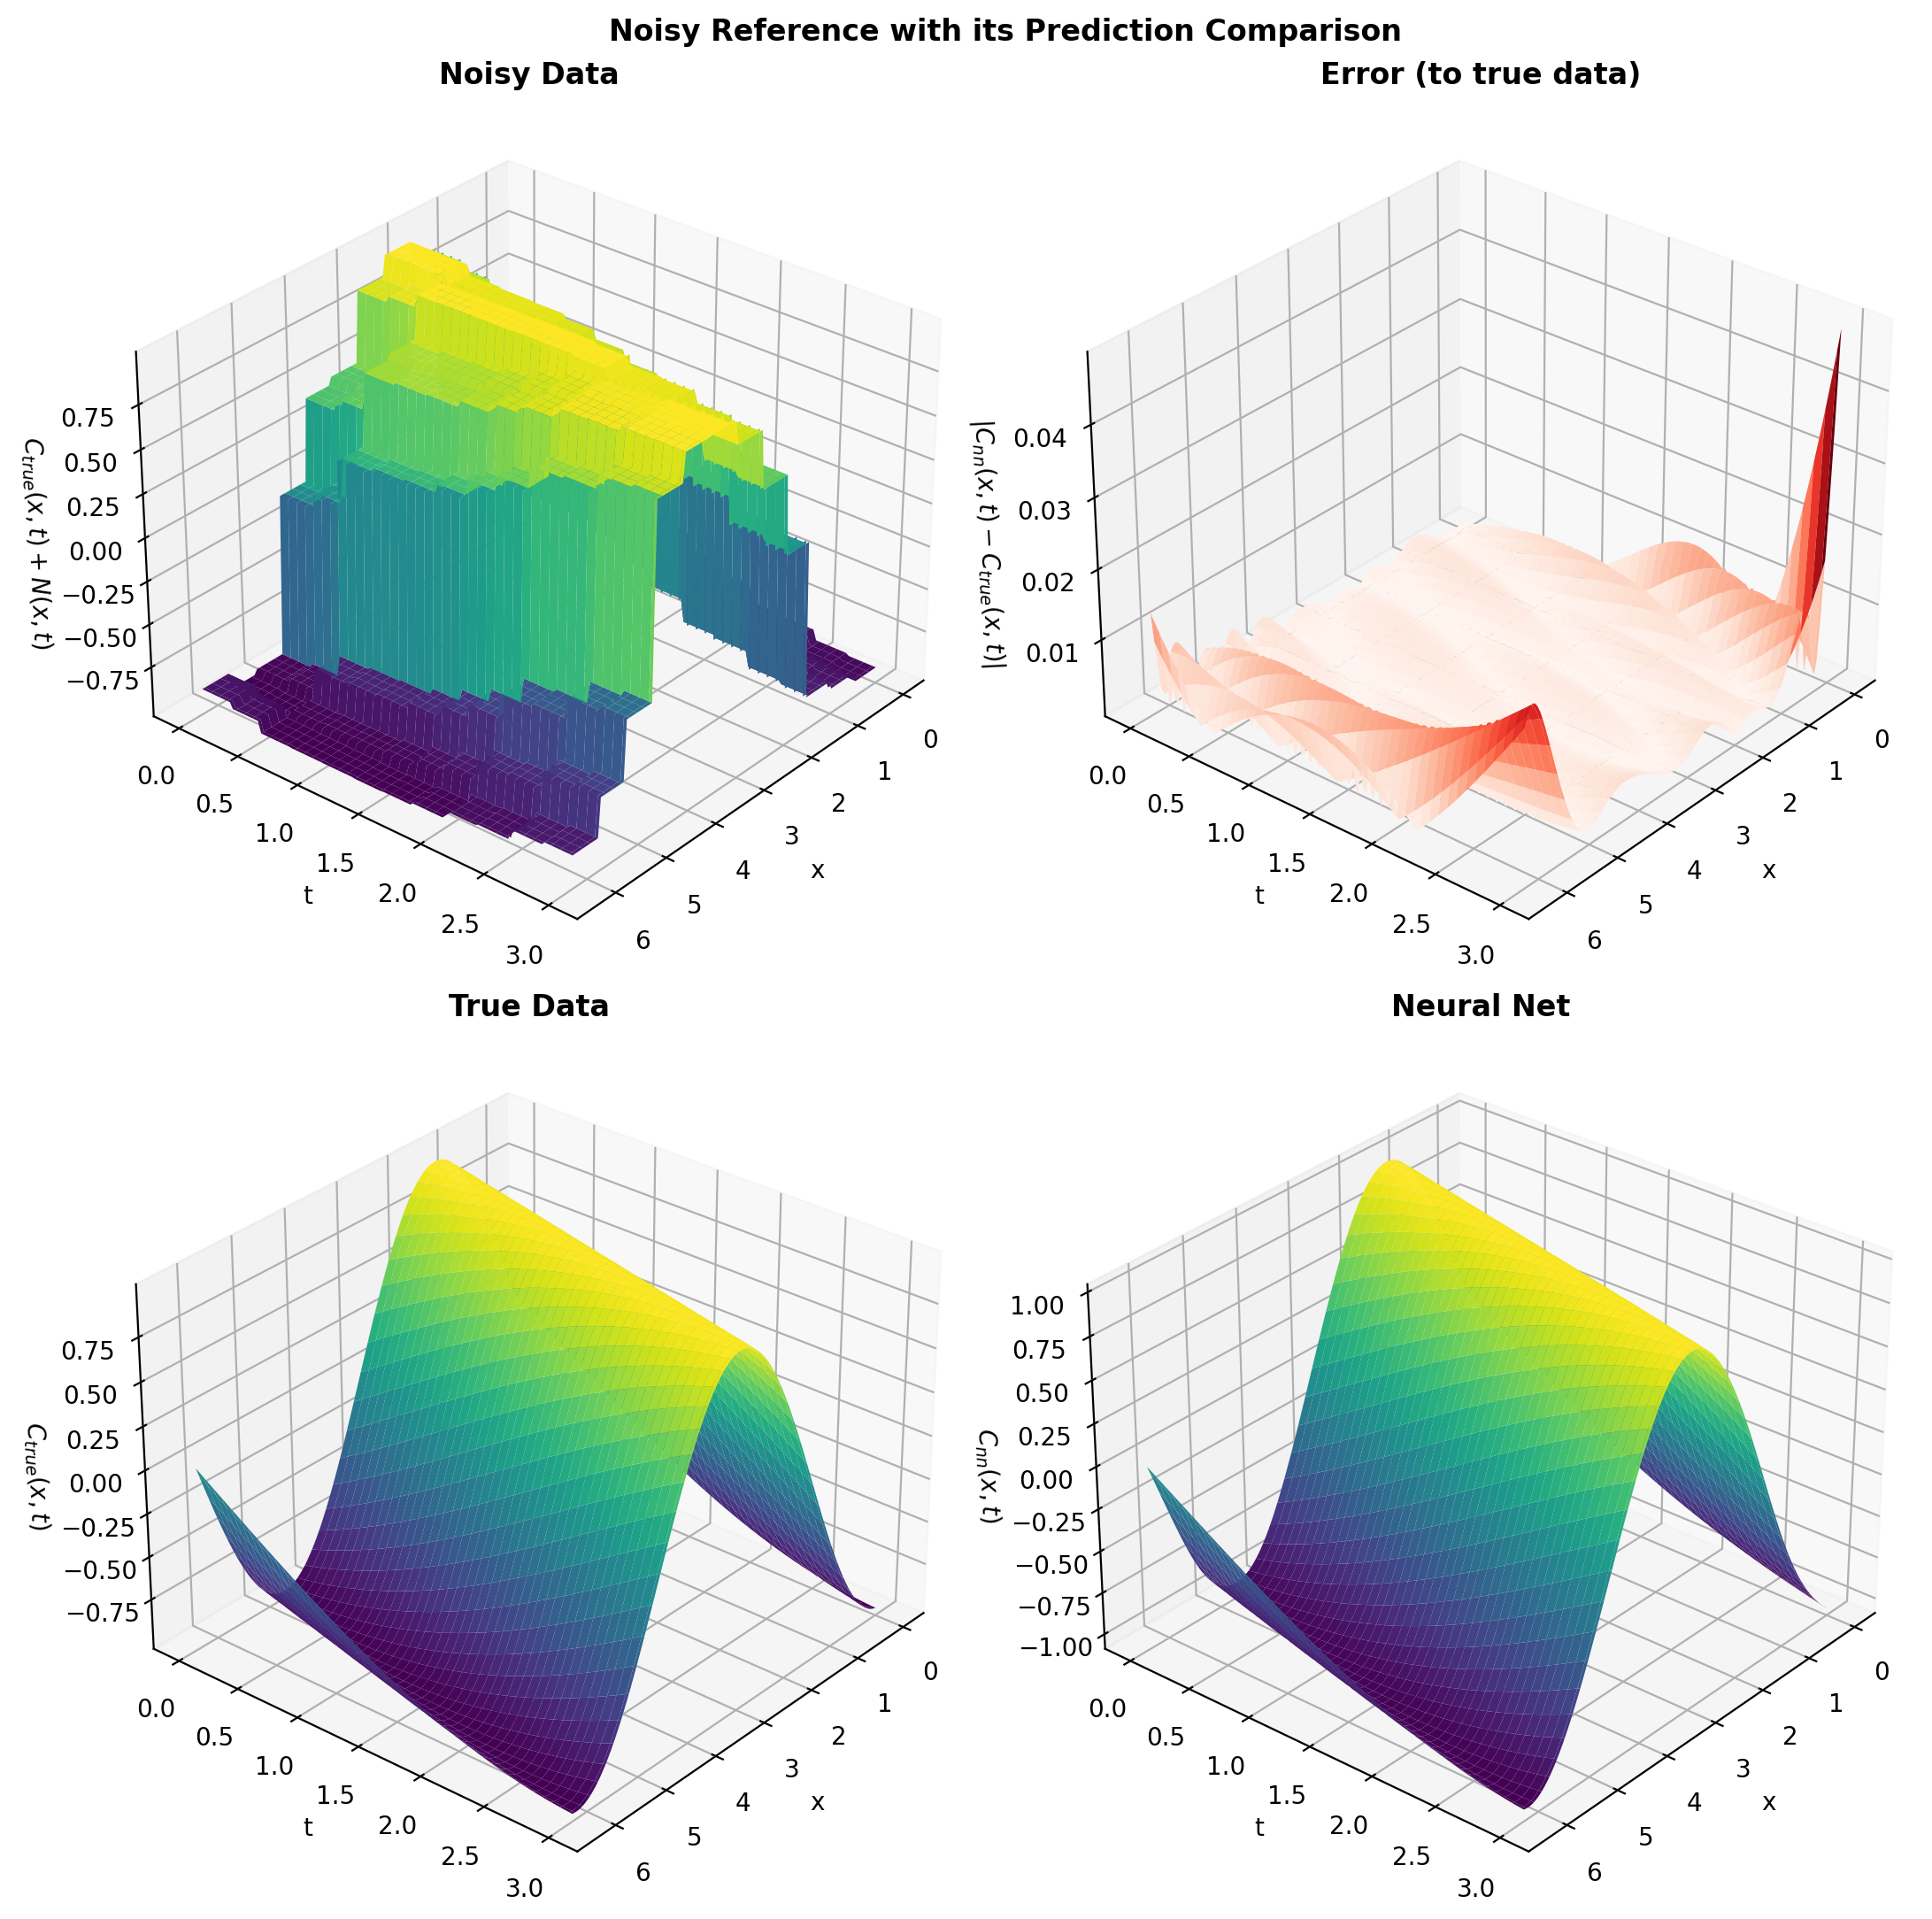

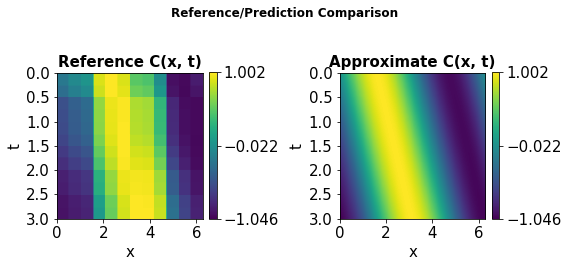

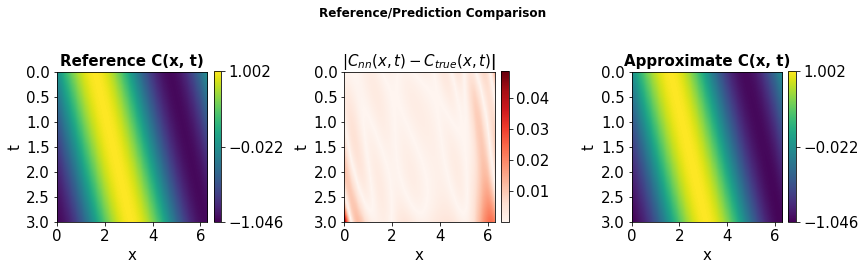

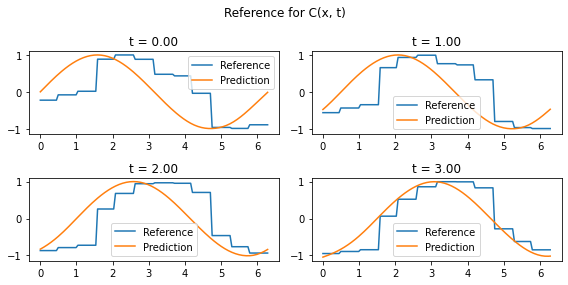

In [9]:
plot_difference_noisy_true_error(sine5_model, R=R, T=T, N=N,
                                 noisy_ref_data=y_train[0],
                                 true_ref_f=lambda x, t: np.sin(x - 0.5*t),
                                 # title_fn_name='Sine',
                                 # file_name='sine_sparse_data_3000e_err_ref.pdf', title=''
                                )
plot_nn_reference(sine5_model, R=R, T=T, N=N, ref_data=y_train[0],
                  # file_name='sine_sparse_data_3000e_diff.pdf', title='',
                 )
plot_nn_reference(sine5_model, R=R, T=T, N=N,
                  ref_data=function_to_data(lambda x, t: np.sin(x - 0.5*t), R, T, N),
                  show_error=True,
                  # file_name='sine_sparse_data_3000e_err.pdf', title='',
                  # title='Prediction of Sparse Data to True Data Comparison'
                 )
plot_difference_to_ref(sine5_model, R=R, N=N, max_t=T,
                       ref_f=data_to_function(y_train[0], R=R, T=T, N=N),
                       # file_name='sine_sparse_data_3000e_time.pdf', title=f'Found v = {get_v(sine5_pinn):.4f}; True v = 0.5'
                       # title=f'Reference, Found v = {get_v(sine5_pinn):.4f}, true v = 0.5'
                      )

## Convective-Dispersion Modeling - Given D

In [8]:
R, T, N = 5., 2., 128
T_l, C_0, x_i = 1., 5., 2.5
D = 0.1

In [14]:
cd_model, cd_pinn = get_model(D=D, v=0.0, with_data=None)

In [10]:
x_train, y_train = get_training_data(R=R, T=T, T_l=T_l, N=N,
                                     f_data=None,
                                     f_ic=lambda x: convective_dispersion(x, T_l, C_0=C_0, D=D, x_i=x_i))

In [11]:
x_train[-1] = x_train[-2]  # Ignore boundary conditions

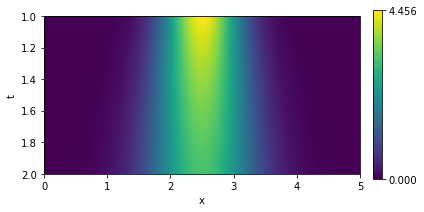

In [31]:
fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(T_l, T, N))
Z = convective_dispersion(xs, ts, C_0=C_0, D=D, x_i=x_i)
im = ax.imshow(Z, extent=[0., R, T, T_l], aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)], fraction=0.025, pad=0.04)
# plt.title('Convective-Dispersion Reference', fontweight='bold')
plt.savefig('convective_dispersion_reference.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

Epoch 500 / [==================================================>] 0.00047 [Batch  0]

[18.59s] Loss: 3.20388 --> 0.00047
Epoch 500 / [==================================================>] 0.00002 [Batch  0]

[18.64s] Loss: 0.00031 --> 0.00002


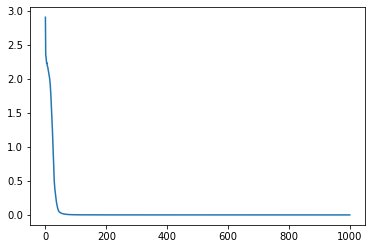

In [15]:
losses = train_pinn(cd_pinn, x_train, y_train, epochs=500)
losses += train_pinn(cd_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=500)
plt.plot(losses)

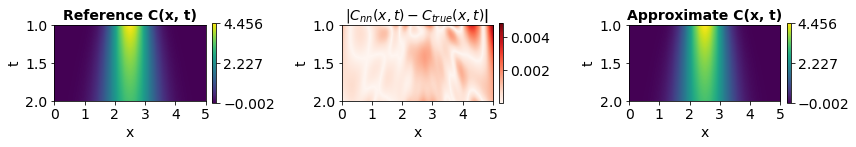

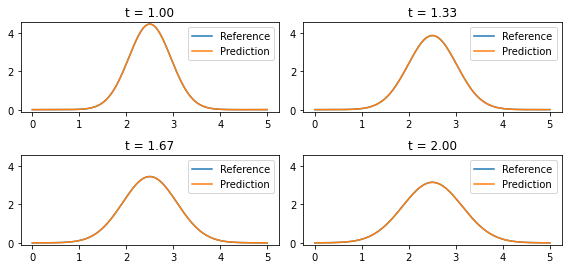

In [17]:
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(T_l, T, N))
plot_nn_reference(cd_model, R=R, T=T, N=N, T_l=T_l,
                  ref_data=convective_dispersion(xs, ts, C_0=C_0, D=D, x_i=x_i),
                  title='', file_name='conv_disp_gen_1000e_D0p1_err.pdf',
                  show_error=True, ratio=0.025, tick_size=14)
plot_difference_to_ref(cd_model, R=R, N=N, max_t=T, T_l=T_l,
                       ref_f=lambda x, t: convective_dispersion(x, t, C_0=C_0, D=D, x_i=x_i),
                       # title=f'Reference',
                       title='', file_name='conv_disp_gen_1000e_D0p1_time.pdf',
                      )

## Convective-Dispersion Modeling - Data-Driven

In [24]:
R, T, N = 5., 2., 128
T_l, C_0, x_i = 1., 5., 2.5
D = 0.1

In [25]:
cd_model, cd_pinn = get_model(D=D, v=0.0)

In [26]:
x_train, y_train = get_training_data(R=R, T=T, T_l=T_l, N=N,
                                     f_data=partial(convective_dispersion, C_0=C_0, D=D, x_i=x_i),
                                     f_ic=lambda x: convective_dispersion(x, T_l, C_0=C_0, D=D, x_i=x_i))

In [27]:
x_train[-1] = x_train[-2]  # Ignore boundary conditions

Epoch 500 / [==================================================>] 0.00046 [Batch  0]

[20.25s] Loss: 6.27899 --> 0.00046
Epoch 500 / [==================================================>] 0.00007 [Batch  0]

[20.61s] Loss: 0.00050 --> 0.00007


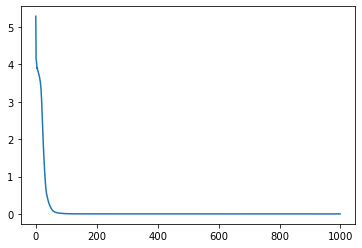

In [28]:
losses = train_pinn(cd_pinn, x_train, y_train, epochs=500)
losses += train_pinn(cd_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=500)
plt.plot(losses)

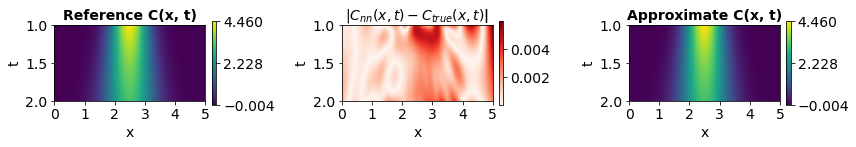

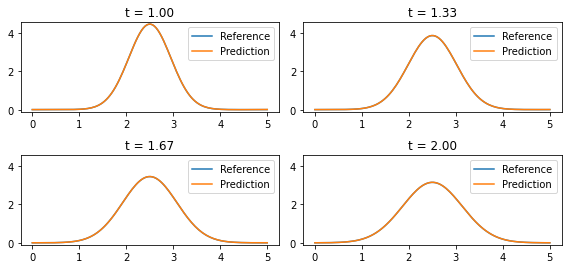

In [30]:
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(T_l, T, N))
plot_nn_reference(cd_model, R=R, T=T, N=N, T_l=T_l,
                  ref_data=convective_dispersion(xs, ts, C_0=C_0, D=D, x_i=x_i),
                  title='', file_name='conv_disp_data_1000e_D0p1_err.pdf',
                  show_error=True, ratio=0.026, tick_size=14)
plot_difference_to_ref(cd_model, R=R, N=N, max_t=T, T_l=T_l,
                       ref_f=lambda x, t: convective_dispersion(x, t, C_0=C_0, D=D, x_i=x_i),
                       # title=f'Reference',
                       title='', file_name='conv_disp_data_1000e_D0p1_time.pdf',
                      )

## Convective-Dispersion Modeling - Learning D

In [2]:
R, T, N = 5., 2., 128
T_l, C_0 = 1., 5.
D = 0.1

In [3]:
cdd_model, cdd_pinn = get_model(D={'trainable': True, 'value': 0.0001}, v=0.0)

In [4]:
x_train, y_train = get_training_data(R=R, T=T, T_l=T_l, N=N,
                                     f_data=partial(convective_dispersion, C_0=C_0, D=D, x_i=2.5),
                                     f_ic=lambda x: convective_dispersion(x, T_l, C_0=C_0, D=D, x_i=2.5))

In [5]:
x_train[-1] = x_train[-2]  # Ignore boundary conditions

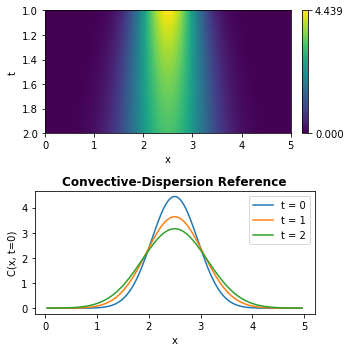

In [6]:
fig = plt.figure(figsize=(5, 5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(211)
Z = tf.reshape(y_train[0], (N, N))
im = ax.imshow(Z, extent=[0., R, T, T_l], aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)], fraction=0.046, pad=0.04)
ax = fig.add_subplot(212)
ax.plot(x_train[0][..., 0][:N], Z[0], label='t = 0')
ax.plot(x_train[0][..., 0][:N], Z[int(N/2)], label='t = 1')
ax.plot(x_train[0][..., 0][:N], Z[-1], label='t = 2')
ax.set_xlabel('x')
ax.set_ylabel('C(x, t=0)')
plt.legend()
plt.title('Convective-Dispersion Reference', fontweight='bold')
plt.tight_layout()
plt.show()

Epoch 500 / [==================================================>] 0.00021 [Batch  0]

[20.42s] Loss: 0.00012 --> 0.00021
Epoch 500 / [==================================================>] 0.00002 [Batch  0]

[20.34s] Loss: 0.00035 --> 0.00002
Found D = 0.0998


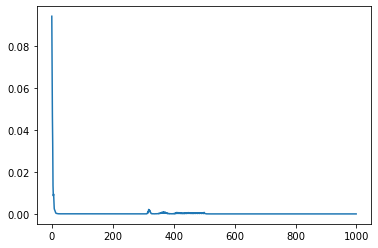

In [9]:
losses = train_pinn(cdd_pinn, x_train, y_train, epochs=500)
losses += train_pinn(cdd_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=500)
plt.plot(losses)
print(f'Found D = {get_D(cdd_pinn):.4f}')

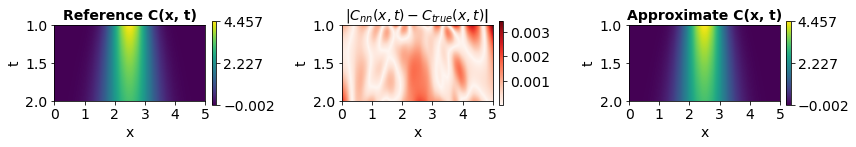

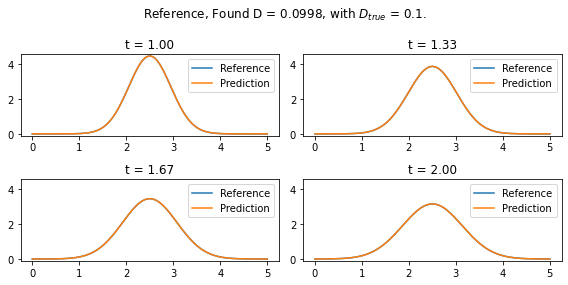

In [17]:
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(T_l, T, N))
plot_nn_reference(cdd_model, R=R, T=T, N=N, T_l=T_l,
                  ref_data=convective_dispersion(xs, ts, C_0=C_0, D=D, x_i=2.5),
                  title='', file_name='conv_disp_data_1000e_D0p1_err.pdf',
                  show_error=True, ratio=0.026, tick_size=14)
plot_difference_to_ref(cdd_model, R=R, N=N, max_t=T, T_l=T_l,
                       ref_f=lambda x, t: convective_dispersion(x, t, C_0=C_0, D=D, x_i=2.5),
                       title=f'Reference, Found D = {get_D(cdd_pinn):.4f}, with $D_{{true}}$ = {D}.',
                       file_name='conv_disp_data_1000e_D0p1_time.pdf')

## Convective-Dispersion - Learning D and v

In [18]:
R, T, N = 5., 2., 128
T_l, C_0 = 1., 5.
D, v = 0.1, 0.5

In [25]:
cddv_model, cddv_pinn = get_model(D={'trainable': True, 'value': 0.0001},
                                  v={'trainable': True, 'value': -0.2})

In [20]:
x_train, y_train = get_training_data(R=R, T=T, T_l=T_l, N=N,
                                     f_data=partial(convective_dispersion, C_0=C_0, D=D, x_i=2.5, v=v),
                                     f_ic=lambda x: convective_dispersion(x, T_l, C_0=C_0, D=D, x_i=2.5, v=v))

In [21]:
x_train[-1] = x_train[-2]  # Ignore boundary conditions

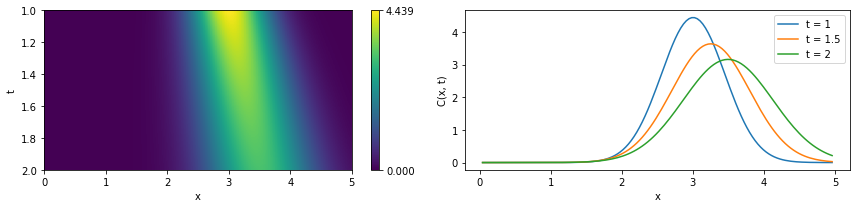

In [22]:
fig = plt.figure(figsize=(12, 3))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(121)
Z = tf.reshape(y_train[0], (N, N))
im = ax.imshow(Z, extent=[0., R, T, T_l], aspect='auto')# aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)])#, fraction=0.026, pad=0.04)
ax = fig.add_subplot(122)
ax.plot(x_train[0][..., 0][:N], Z[0], label='t = 1')
ax.plot(x_train[0][..., 0][:N], Z[int(N/2)], label='t = 1.5')
ax.plot(x_train[0][..., 0][:N], Z[-1], label='t = 2')
ax.set_xlabel('x')
ax.set_ylabel('C(x, t)')
plt.legend()
# plt.title('Convective-Dispersion Reference', fontweight='bold')
plt.tight_layout()
plt.savefig('conv_disp_moving_and_diffusing.pdf')
plt.show()

Epoch 1500 \ [==================================================>] 0.00022 [Batch  0]

[45.21s] Loss: 5.94680 --> 0.00022
Epoch 500 / [==================================================>] 0.00015 [Batch  0]

[16.00s] Loss: 0.00022 --> 0.00015
Found D = 0.0986


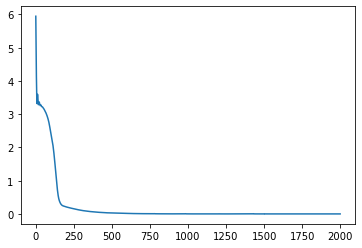

In [26]:
losses = train_pinn(cddv_pinn, x_train, y_train, 
                    batch_size=N*N, epochs=1500)
losses += train_pinn(cddv_pinn, x_train, y_train,
                    batch_size=N*N,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    epochs=500)
plt.plot(losses)
print(f'Found D = {get_D(cddv_pinn):.4f}')

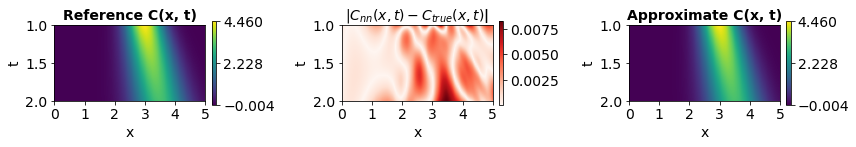

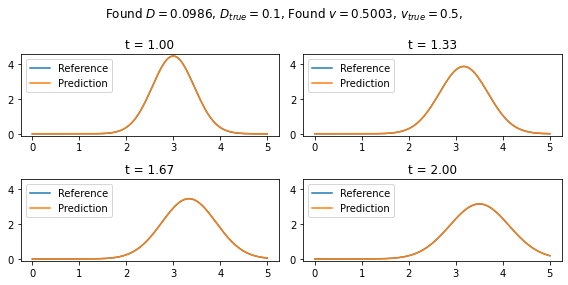

In [27]:
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(T_l, T, N))
plot_nn_reference(cddv_model, R=R, T=T, N=N, T_l=T_l,
                  ref_data=convective_dispersion(xs, ts, C_0=C_0, D=D, x_i=2.5, v=v),
                  title='', file_name='conv_disp_learn_1500e_D0p1_v0p5_err.pdf',
                  show_error=True, ratio=0.026, tick_size=14)
plot_difference_to_ref(cddv_model, R=R, N=N, max_t=T, T_l=T_l,
                       ref_f=lambda x, t: convective_dispersion(x, t, C_0=C_0, D=D, x_i=2.5, v=v),
                       title=f'Found $D = {get_D(cddv_pinn):.4f}$, $D_{{true}} = {D}$, '
                             f'Found $v = {get_v(cddv_pinn):.4f}$, $v_{{true}} = {v}$, ',
                       file_name='conv_disp_learn_1500e_D0p1_v0p5_time.pdf')

## Sine Curve - Solution - Dynamic v = v(x, t)

In [32]:
# R, T, N, = 1., 2.*np.pi, 128
R, T, N, = 2.*np.pi, 1., 128
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(0., T, N))

In [35]:
def v_dynamic(x, t):
    return 2. * (np.sin(np.pi*2*t) + 1.)

def v_dynamic_tf(x, t):
    return 2. * (tf.sin(np.pi*2*t) + 1.)

def v_dynamic_ic(x):
    return np.sin(x)

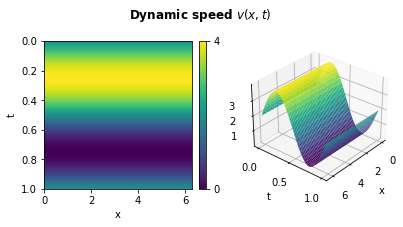

In [36]:
fig = plt.figure(figsize=(6, 3))
fig.patch.set_facecolor('white')

Z = v_dynamic(xs, ts)

ax = fig.add_subplot(121)
im = ax.imshow(Z, extent=[0., R, T, 0.], aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)], fraction=0.046, pad=0.04)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(xs, ts, Z.reshape(xs.shape), cmap='viridis')
ax.view_init(30, 40)  # Rotate a little
ax.set_xlabel('x')
ax.set_ylabel('t')

plt.suptitle('Dynamic speed $v(x, t)$', fontweight='bold')
plt.tight_layout()
plt.show()

In [37]:
sine_d_model, sine_d_pinn = get_model(D=0.0,
                                      v={'trainable': False, 'value':
                                         # lambda x, t: tf.reshape(1./3. * np.pi * (1./2. + tf.sin(np.pi * x)**2) * tf.cos(t), (-1, 1))},
                                         tf.cast(tf.reshape(v_dynamic_tf(xs, ts), (-1, 1)), tf.float32)},
                                         # v_dynamic(xs, ts).reshape(-1, 1)},
                                      # layers=10*[128],
                                      with_data=False)
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     f_data=None,
                                     f_ic=v_dynamic_ic)

In [38]:
x_train[-1] = x_train[-2]  # Remove boundary condition

In [39]:
print('Mean  ', tf.reduce_mean(tf.keras.losses.mean_squared_error(sine_d_pinn(x_train), y_train)).numpy())
y_pred = sine_d_pinn(x_train)
print('Custom', tf.reduce_mean((
    (y_pred[0] - y_train[0]) ** 2 +  # pde
    (y_pred[1] - y_train[1]) ** 2 +  # ic
    (y_pred[2] - y_train[2]) ** 2  # bc
       ) / 3.
).numpy())

print('\nPDE   ', tf.reduce_mean((y_pred[0] - y_train[0]) ** 2).numpy())
print('IC    ', tf.reduce_mean((y_pred[1] - y_train[1]) ** 2).numpy())
print('BC    ', tf.reduce_mean((y_pred[2] - y_train[2]) ** 2).numpy())

Mean   0.15890533
Custom 0.15890533

PDE    0.0010814052
IC     0.47563457
BC     0.0


In [40]:
# sine_d_pinn(x_train)

Epoch 1000 | [==================================================>] 0.00196 [Batch  0]

[31.33s] Loss: 0.47672 --> 0.00196


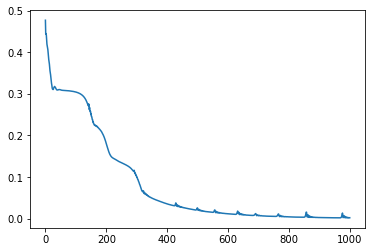

In [41]:
plt.plot(train_pinn(sine_d_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    batch_size=N*N, epochs=1000))
plt.show()

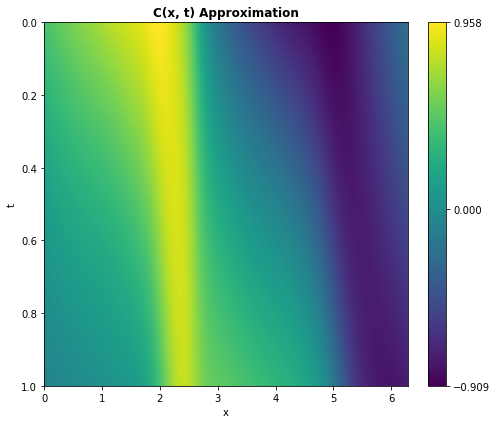

In [34]:
plot_nn_colorbar(sine_d_model, R, T, N)
# plot_difference_to_ref(model, R=R, max_t=T, N=N, ref_f=None)

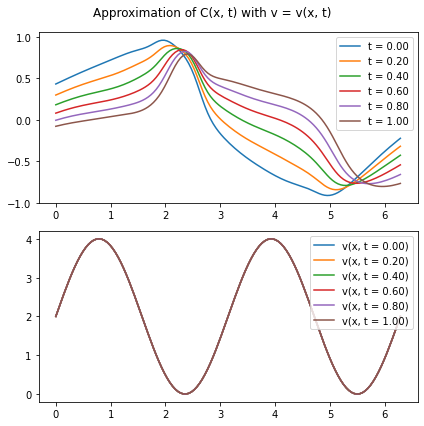

In [35]:
n = 6
t_splits = np.linspace(0., T, n)# T, n)
fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(211)
for i in range(n):
    xt = tf.concat((np.linspace([0], [R], N), tf.constant(
        t_splits[i], shape=(N, 1))), axis=1)
    ax.plot(np.linspace(0, R, N), sine_d_model(xt), label=f't = {t_splits[i]:.2f}')
ax.legend()

ax = fig.add_subplot(212)
for i in range(n):
    ax.plot(np.linspace(0, R, N),
            v_dynamic(np.linspace(0, R, N), t_splits[i]),
            label=f'v(x, t = {t_splits[i]:.2f})')
ax.legend()
plt.suptitle('Approximation of C(x, t) with v = v(x, t)')
plt.tight_layout()
plt.show()

Creating Animation: 100.00%


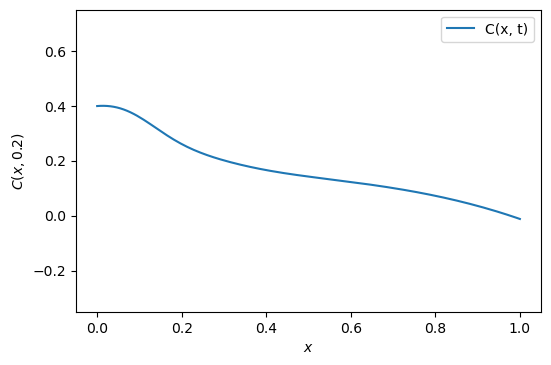

In [24]:
plot_t_animation(sine_d_model, R, T, N, y_lim=[-0.35, 0.75],
                 t=0.2)#, file_name=None)

### Gradient Flow Analysis

In [163]:
grads = []
for i in range(len(y_train)):
    with tf.GradientTape() as tape:
        loss = (sine_d_pinn(x_train)[i] - y_train[i]) ** 2
    grads.append(tape.gradient(loss, sine_d_pinn.trainable_weights))

In [164]:
pde_grads = [g.numpy().flatten() if g is not None else [0.0] for g in grads[0]]
ic_grads  = [g.numpy().flatten() if g is not None else [0.0] for g in grads[1]]
bc_grads  = [g.numpy().flatten() if g is not None else [0.0] for g in grads[2]]

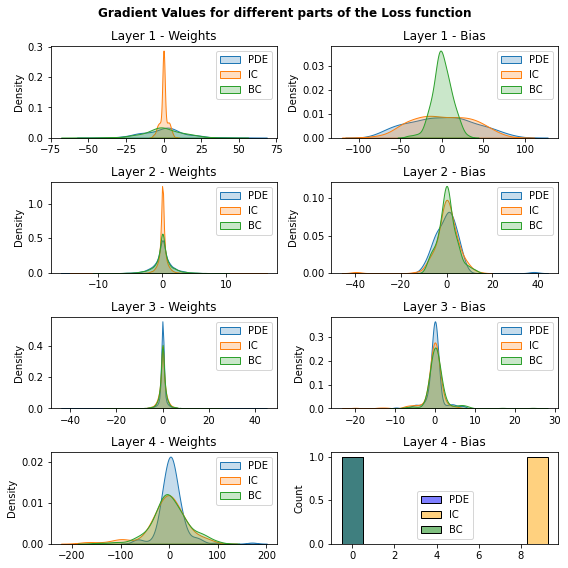

In [182]:
fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor('white')
for i in range(len(pde_grads)):
    subplot = 421 + i
    ax = fig.add_subplot(subplot)
    for g, label in zip([pde_grads, ic_grads, bc_grads], ['PDE', 'IC', 'BC']):
        if not np.var(g[i]):
            sns.histplot(g[i], ax=ax, label=label, alpha=0.5,
                        color='blue' if label=='PDE' else ('orange' if label=='IC' else 'green'))
        else:
            sns.kdeplot(g[i], fill=True, ax=ax, label=label)
    ax.legend()
    ax.title.set_text(f'Layer {int((i+2)/2)} - {"Bias" if i % 2 == 1 else "Weights"}')
plt.suptitle('Gradient Values for different parts of the Loss function',
            fontweight='bold')
plt.tight_layout()
plt.show()

## Gaussian - Dynamic v = v(x, t)

In [154]:
# R, T, N, = 1., 2.*np.pi, 128
R, T, N, = 1, np.pi, 128
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(0., T, N))

In [155]:
def v_dynamic(x, t):
    return 1./3. * np.pi * (1./2. + np.sin(np.pi * x)**2) * np.cos(t)

def v_dynamic_tf(x, t):
    return 1./3. * np.pi * (1./2. + tf.sin(np.pi * x)**2) * tf.cos(t)

def v_dynamic_ic(x):
    return np.exp(-400*(x - 0.1)**2)

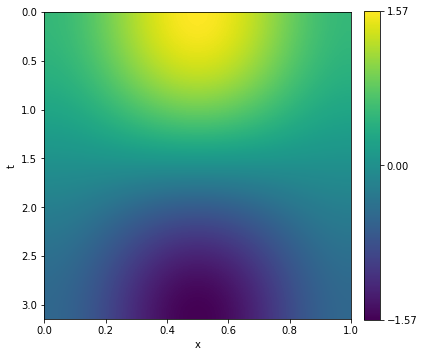

In [156]:
fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor('white')

Z = v_dynamic(xs, ts)

ax = fig.add_subplot(111)
# ax = fig.add_subplot(121)
im = ax.imshow(Z, extent=[0., R, T, 0.], aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)], fraction=0.046, pad=0.04)

# ax = fig.add_subplot(122, projection='3d')
# ax.plot_surface(xs, ts, Z.reshape(xs.shape), cmap='viridis')
# ax.view_init(30, 40)  # Rotate a little
# ax.set_xlabel('x')
# ax.set_ylabel('t')
# 
# plt.suptitle('Dynamic speed $v(x, t)$', fontweight='bold')
plt.tight_layout()
# plt.savefig('dis_gauss_dyn_speed.pdf', bbox_inches='tight')
plt.show()

In [157]:
gauss_d_model, gauss_d_pinn = get_model(D=0.0,
                                      v={'trainable': False, 'value':
                                         tf.cast(tf.reshape(v_dynamic_tf(xs, ts), (-1, 1)), tf.float32)},
                                         # v_dynamic(xs, ts).reshape(-1, 1)},
                                      # layers=10*[128],
                                      with_data=False)

In [158]:
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     f_data=None,
                                     f_ic=v_dynamic_ic)

In [159]:
x_train[-1] = x_train[-2]  # Remove boundary condition

Epoch 3000 | [==================================================>] 0.00491 [Batch  0]

[81.08s] Loss: 0.06258 --> 0.00491


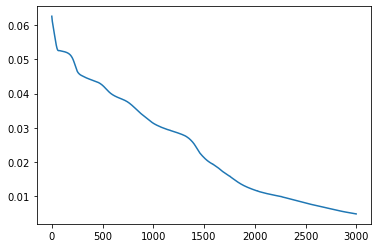

In [160]:
plt.plot(train_pinn(gauss_d_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    batch_size=N*N, epochs=3000))
plt.show()

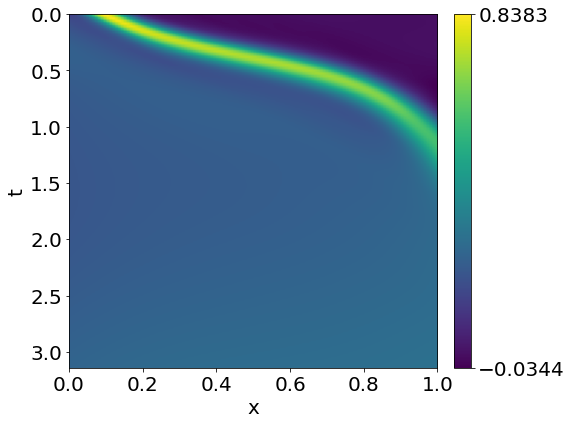

In [161]:
# Should be C(x, 2pi) = C(x, 0)
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)
xs = np.linspace(0., R, N)
ts = np.linspace(0, T, N)
Xs, Ts = np.meshgrid(xs, ts)
Z = gauss_d_model(tf.concat(
    (Xs.reshape(-1, 1), Ts.reshape(-1, 1)), axis=1)
              ).numpy().reshape(Xs.shape)

im = ax.imshow(Z, extent=[0., R, T, 0.], aspect='auto')

ax.set_xlabel('x', size=20)
ax.set_ylabel('t', size=20)
plt.xticks(size=20)
plt.yticks(size=20)

cb = plt.colorbar(im, ticks=[np.min(Z), np.max(Z)], fraction=0.046, pad=0.04)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)
plt.tight_layout()
plt.savefig('sol_dyn_v_tight.pdf')
plt.show()

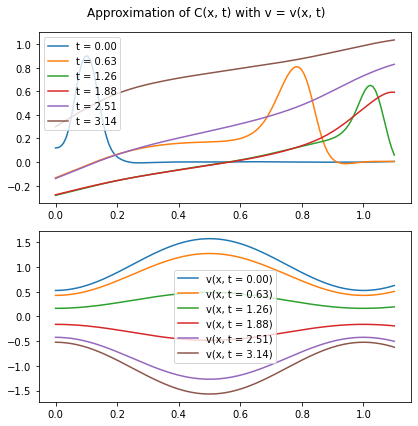

In [89]:
n = 6
t_splits = np.linspace(0., T, n)# T, n)
fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(211)
for i in range(n):
    xt = tf.concat((np.linspace([0], [R], N), tf.constant(
        t_splits[i], shape=(N, 1))), axis=1)
    ax.plot(np.linspace(0, R, N), gauss_d_model(xt), label=f't = {t_splits[i]:.2f}')
ax.legend()

ax = fig.add_subplot(212)
for i in range(n):
    ax.plot(np.linspace(0, R, N),
            v_dynamic(np.linspace(0, R, N), t_splits[i]),
            label=f'v(x, t = {t_splits[i]:.2f})')
ax.legend()
plt.suptitle('Approximation of C(x, t) with v = v(x, t)')
plt.tight_layout()
plt.show()

#### Move on with training boundary conditions too

In [49]:
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     f_data=None,
                                     f_ic=v_dynamic_ic)

Epoch 1500 \ [==================================================>] 0.00006 [Batch  0]

[41.45s] Loss: 0.01291 --> 0.00006


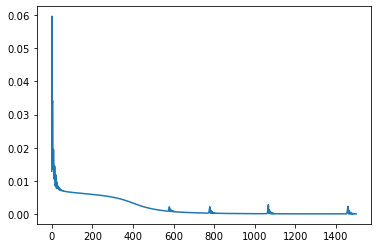

In [50]:
plt.plot(train_pinn(gauss_d_pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    batch_size=N*N, epochs=1500))
plt.show()

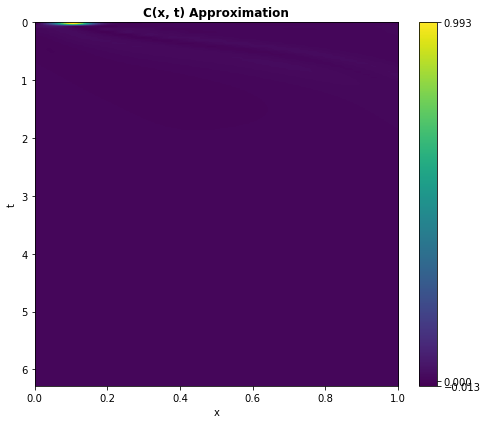

In [51]:
plot_nn_colorbar(gauss_d_model, R, T, N)

# Remove ...

## Sine Curve - Discovery - Dynamic v(x, t) = sin(2x)

In [2]:
from Pinn.PinnV import get_v_model

------- Loaded PINN Dynamic v(x, t) -------
GPU is available ['/physical_device:GPU:0']


In [3]:
R, T, N, = 2.*np.pi, 1., 128
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(0., T, N))

In [4]:
def v_dynamic(x, t):
    return 2. * (np.sin(2*x) + 1.)

def C_ref(x, t):
    return np.sin(x - v_dynamic(x, t)*t)

def v_dynamic_ic(x):
    return np.sin(x)

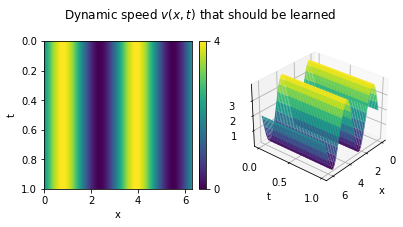

In [5]:
fig = plt.figure(figsize=(6, 3))
fig.patch.set_facecolor('white')

Z = v_dynamic(xs, ts)

ax = fig.add_subplot(121)
im = ax.imshow(Z, extent=[0., R, T, 0.], aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)], fraction=0.046, pad=0.04)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(xs, ts, Z.reshape(xs.shape), cmap='viridis')
ax.view_init(30, 40)  # Rotate a little
ax.set_xlabel('x')
ax.set_ylabel('t')

plt.suptitle('Dynamic speed $v(x, t)$ that should be learned')
plt.tight_layout()
plt.show()

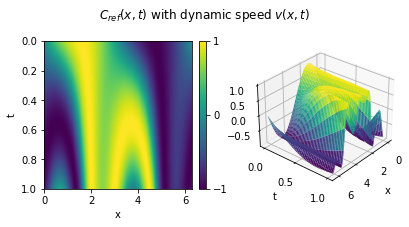

In [6]:
fig = plt.figure(figsize=(6, 3))
fig.patch.set_facecolor('white')

Z = C_ref(xs, ts)

ax = fig.add_subplot(121)
im = ax.imshow(Z, extent=[0., R, T, 0.], aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)], fraction=0.046, pad=0.04)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(xs, ts, Z.reshape(xs.shape), cmap='viridis')
ax.view_init(30, 40)  # Rotate a little
ax.set_xlabel('x')
ax.set_ylabel('t')

plt.suptitle('$C_{ref}(x,t)$ with dynamic speed $v(x, t)$')
plt.tight_layout()
plt.show()

In [7]:
model, pinn, v_model = get_v_model(D=0.0)
x_train, y_train = get_training_data(R=R, T=T, N=N,
                                     f_data=C_ref,
                                     f_ic=v_dynamic_ic)

In [8]:
x_train[-1] = x_train[-2]  # Remove boundary conditions

Epoch 1000 | [==================================================>] 0.06049 [Batch  0]

[31.12s] Loss: 0.08097 --> 0.06049


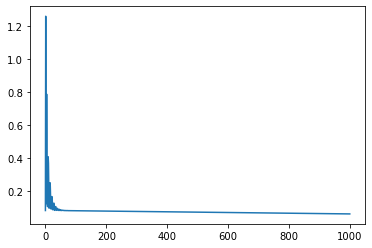

In [18]:
plt.plot(train_pinn(pinn, x_train, y_train,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    batch_size=N*N, epochs=1000))
plt.show()

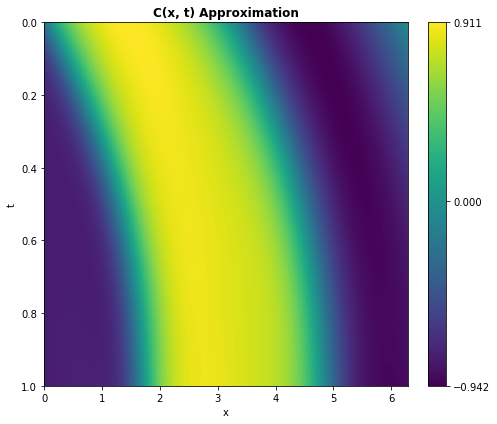

In [19]:
plot_nn_colorbar(model, R, T, N)

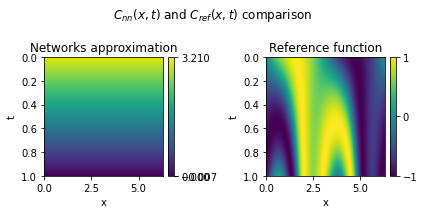

In [20]:
fig = plt.figure(figsize=(6, 3))
fig.patch.set_facecolor('white')

Z = v_model(tf.concat((xs.reshape(-1,1), ts.reshape(-1,1)), axis=1))

ax = fig.add_subplot(121)
im = ax.imshow(Z, extent=[0., R, T, 0.], aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)], fraction=0.046, pad=0.04)
plt.title('Networks approximation')

Z = C_ref(xs, ts)
ax = fig.add_subplot(122)
im = ax.imshow(Z, extent=[0., R, T, 0.], aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)], fraction=0.046, pad=0.04)
plt.title('Reference function')

plt.suptitle('$C_{nn}(x,t)$ and $C_{ref}(x,t)$ comparison')
plt.tight_layout()
plt.show()